<a href="https://colab.research.google.com/github/emanbuc/uvadlc_notebooks/blob/master/dl2_bnn_tut2_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Comparison to other methods of uncertainty quantification

**Filled notebook:**
- Latest version (V04/23): [![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Id9lq9FdMdXNDoxI2MyqjBsWNepG9EhG#scrollTo=8XcJ8d_mpifP)

**Empty notebook**:
- Latest version (V04/23): this notebook

Visit also the DL2 tutorial [Github repo](https://github.com/phlippe/uvadlc_notebooks) and associated [Docs page](https://uvadlc-notebooks.readthedocs.io/en/latest/).

**Authors:**
Ilze Amanda Auzina, Leonard Bereska, Alexander Timans and Eric Nalisnick

-------------------------------------------------

In this tutorial we will investigate what are some benefits of Bayesian Neural Networks (BNN) over point estimate Neural Networks. We will also look at other uncertainty quantification methods, including conformal prediction.

Import standard libraries and setting random seeds for reproducibility.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

torch.manual_seed(45)
np.random.seed(45)

### Simulate Data

Let's simulate a wiggly line and draw observations in separated regions...

In [2]:
def get_simple_data_train():
    x = np.linspace(-.2, 0.2, 500)
    x = np.hstack([x, np.linspace(.6, 1, 500)])
    eps = 0.02 * np.random.randn(x.shape[0])
    y = x + 0.3 * np.sin(2 * np.pi * (x + eps)) + 0.3 * np.sin(4 * np.pi * (x + eps)) + eps
    x_train = torch.from_numpy(x).float()[:, None]
    y_train = torch.from_numpy(y).float()
    return x_train, y_train

In [3]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlim([-.5, 1.5])
    plt.ylim([-1.5, 2.5])
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    x_train, y_train = get_simple_data_train()

    x_true = np.linspace(-.5, 1.5, 1000)
    y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

    ax.plot(x_train, y_train, 'ko', markersize=4, label="observations")
    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, fontsize=15, frameon=False)
    plt.show()

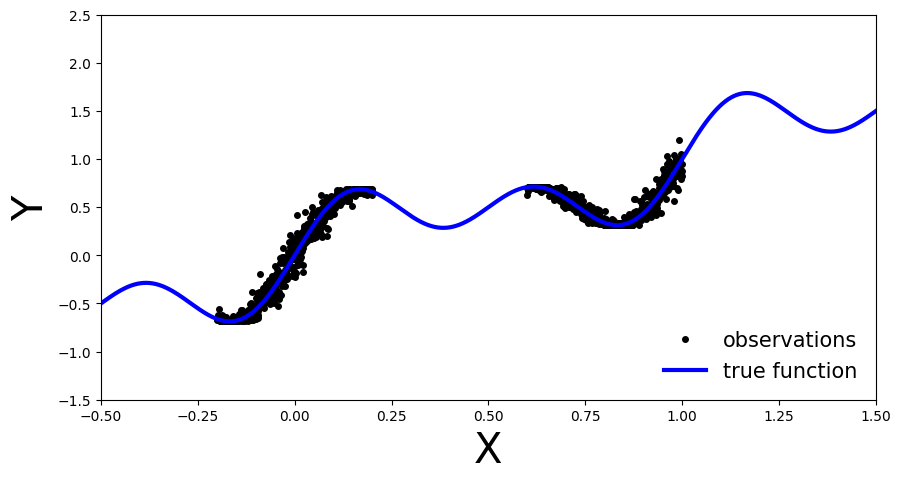

In [4]:
plot_generic()

As you can see, we have the true function in blue. The observations are observable in two regions of the function and there is some noise in their measurement. We will use this simple data to showcase the differences between BNNs and deterministic NNs.

### Define non-Bayesian Neural Network

First let's create our point estimate neural network, in other words a standard fully connected MLP. We will define the number of hidden layers dynamically so we can reuse the same class for different depths.  We will also add a *dropout* flag, this will allow us to easily use the same architecture for our BNN.

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
        super().__init__()

        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.activation = nn.Tanh()

        # dynamically define architecture
        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = nn.ModuleList(layer_list)

    def forward(self, input):
        hidden = self.activation(self.layers[0](input))
        for layer in self.layers[1:-1]:
            hidden_temp = self.activation(layer(hidden))

            if self.use_dropout:
                hidden_temp = self.dropout(hidden_temp)

            hidden = hidden_temp + hidden  # residual connection

        output_mean = self.layers[-1](hidden).squeeze()
        return output_mean

### Train one deterministic NN

**Training**

Now let's train our MLP with the training data we generated above:

In [6]:
losses=[]
def train(net, train_data):
    x_train, y_train = train_data
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    progress_bar = trange(3000)
    for _ in progress_bar:
        optimizer.zero_grad()
        loss = criterion(y_train, net(x_train))
        progress_bar.set_postfix(loss=f'{loss / x_train.shape[0]:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().item())
    return net

In [7]:
train_data = get_simple_data_train()
x_test = torch.linspace(-.5, 1.5, 3000)[:, None]  # test over the whole range

net = MLP(hidden_dim=30, n_hidden_layers=2)
net = train(net, train_data)
y_preds = net(x_test).clone().detach().numpy()

  0%|          | 0/3000 [00:00<?, ?it/s]

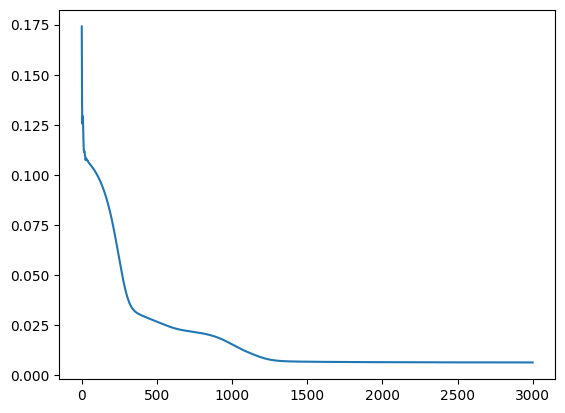

In [8]:
plt.plot(losses)

**Evaluate**

Let's investigate how our deterministic MLP generalizes over the entire domain of our input variable $x$ (the model was only trained on the observations, now we will also pass in data outside this region)

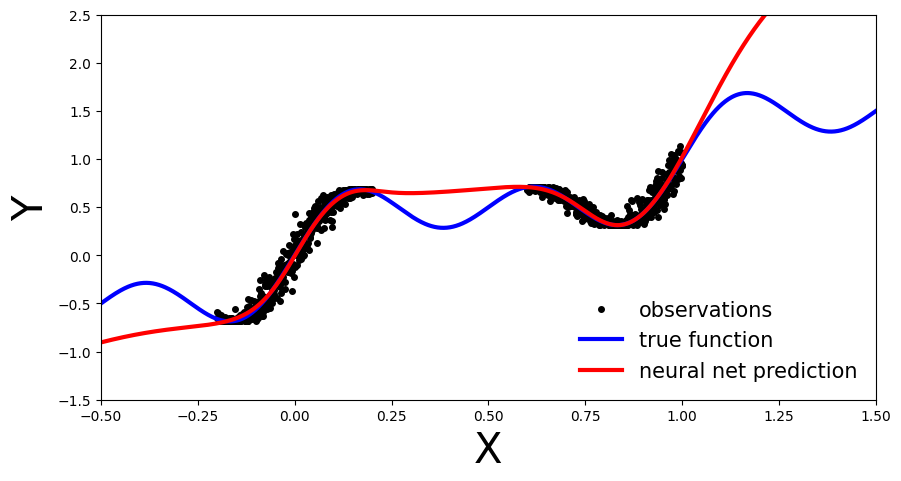

In [9]:
def plot_predictions(x_test, y_preds):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'r-', linewidth=3, label='neural net prediction')

    plot_generic(add_predictions)
plot_predictions(x_test, y_preds)

We can see that our deterministic MLP (red line) has correctly learned the data distribution in the training regions, however, as the model has not learned the underlying sinusoidal wave function, it's predictions outside the training region are inaccurate. As our MLP is a point estimate NN we have no measure confidence in the predictions outside the training region. In the upcoming sections let's see how this compares to BNN.

### Deep Ensemble

Deep ensembles were first introduced by [Lakshminarayanan et al. (2017)](https://arxiv.org/abs/1612.01474). As the name implies multiple point estimate NN are trained, *an ensemble*, and the final prediction is computed as an average across the models. From a Bayesian perspective the different point estimates correspond to modes of a Bayesian posterior. This can be interpreted as approximating the posterior with a distribution parametrized as multiple Dirac deltas:

$$
q_{\phi}(\theta | D) = \sum_{\theta_{i} ∈ ϕ} \alpha_{\theta_{i}} δ_{\theta_{i}}(\theta)
$$
where $\alpha_{\theta_{i}}$ are positive constants such that their sum is equal to one.

**Training**

We will reuse the MLP architecture introduced before, simply now we will train an ensemble of such models

In [10]:
ensemble_size = 5
ensemble = [MLP(hidden_dim=10, n_hidden_layers=5) for _ in range(ensemble_size)]
for net in ensemble:
    train(net, train_data)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

**Evaluate**

Same as before, let's investigate how our Deep Ensemble performs on the entire data domain of our input variable $x$.

In [11]:
y_preds = [np.array(net(x_test).clone().detach().numpy()) for net in ensemble]

Plot each ensemble member's predictive function.

In [12]:
def plot_multiple_predictions(x_test, y_preds):
    def add_multiple_predictions(ax):
        for idx in range(len(y_preds)):
            ax.plot(x_test, y_preds[idx], '-', linewidth=3)

    plot_generic(add_multiple_predictions)

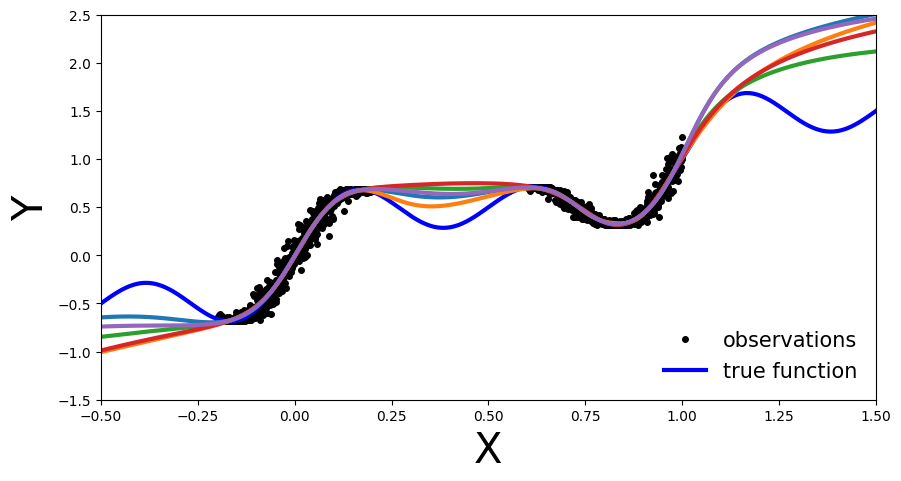

In [13]:
plot_multiple_predictions(x_test, y_preds)

In this plot the benefit of an ensemble approach is not immediately clear. Still on the regions outside the training data each of the trained NN is inaccurate. So what is the benefit you might ask.

Well let's plot the above in a slightly different way: let's visualize the ensemble's **uncertainty bands**.
> From a Bayesian perspective we want to quantify the model's uncertainty on its prediction. This is done via the marginal $p(y|x, D)$, which can be computed as:

$$
p(y|x, D) = \int_{\theta}p(y|x,\theta')p(\theta'|D)d\theta'
$$

> In practice, for Deep Ensembles we approximate the above by computing the mean and standard deviation across the ensemble. Meaning $p(\theta|D)$ represents the parameters of one of the trained models, $\theta_{i} ∼ p(\theta|D)$, which we then use to compute $y_{i} = f(x,\theta_{i})$, representing $p(y|x,\theta')$.


In [14]:
def plot_uncertainty_bands(x_test, y_preds):
    y_preds = np.array(y_preds)
    y_mean = y_preds.mean(axis=0)
    y_std = y_preds.std(axis=0)

    def add_uncertainty(ax):
        ax.plot(x_test, y_mean, '-', linewidth=3, color="#408765", label="predictive mean")
        ax.fill_between(x_test.ravel(), y_mean - 2 * y_std, y_mean + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plot_generic(add_uncertainty)

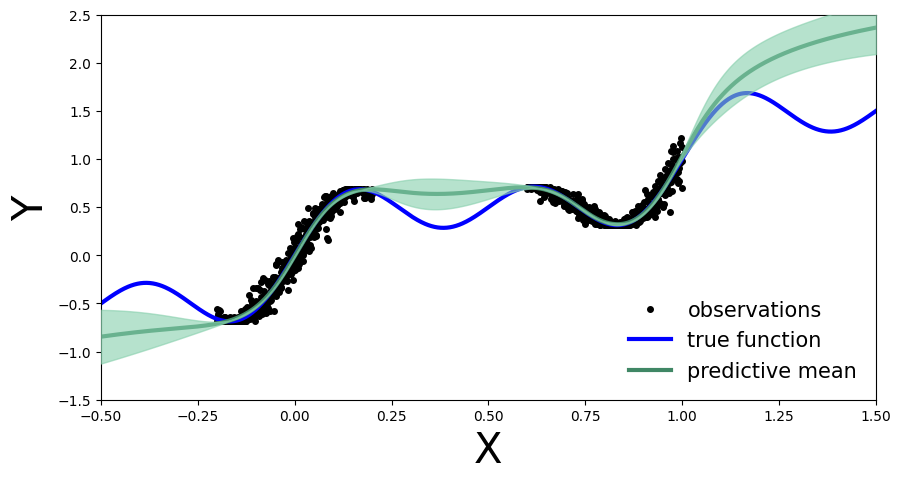

In [15]:
plot_uncertainty_bands(x_test, y_preds)

Now we see the benefit of a Bayesian approach. Outside the training region we not only have the point estimate, but also model's uncertainty about its prediction.

### Monte Carlo Dropout

First we create our MC-Dropout Network. As you can see in the code below, creating a dropout network is extremely simple:
We can reuse our existing network architecture, the only alteration is that during the forward pass we randomly *switch off* (zero) some of the elements of the input tensor.

The Bayesian interpretation of MC-Dropout is that we can see each dropout configuration as a different sample from the approximate posterior distribution $\theta_{i} ∼ q(\theta|D)$.


**Training**

In [16]:
net_dropout = MLP(hidden_dim=10, n_hidden_layers=5, use_dropout=True)
net_dropout = train(net_dropout, train_data)

  0%|          | 0/3000 [00:00<?, ?it/s]

**Evaluate**

Similarly to Deep Ensembles, we pass the test data multiple times through the MC-Dropout network. We do so to obtain $y_{i}$ at the different parameter settings, $\theta_{i}$ of the network, $y_{i}=f(x,\theta_{i})$, governed by the dropout mask.

>This is the main difference compared to dropout implementation in a deterministic NN where it serves as a regularization term. In normal dropout application during test time the dropout is **not** applied. Meaning that all connections are present, but the weights are [adjusted](https://cs231n.github.io/neural-networks-2/)

In [17]:
n_dropout_samples = 100

# compute predictions, resampling dropout mask for each forward pass
y_preds = [net_dropout(x_test).clone().detach().numpy() for _ in range(n_dropout_samples)]
y_preds = np.array(y_preds)

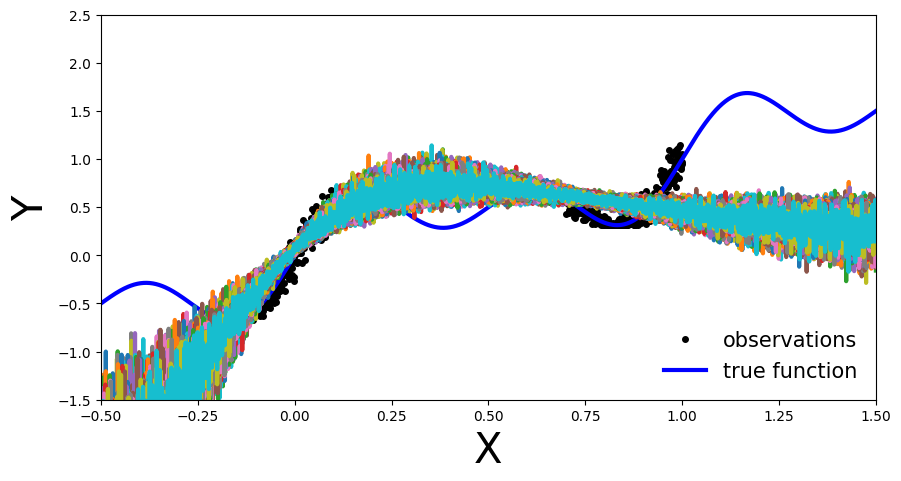

In [18]:
plot_multiple_predictions(x_test, y_preds)

In the above plot each colored line (apart from blue) represents a different parametrization, $\theta_{i}$, of our MC-Dropout Network.

Likewise to the Deep Ensemble Network, we can also compute the MC-dropout's **uncertainty bands**.

> The approach in practice is the same as before: we compute the mean and standard deviation across each dropout mask, which corresponds to the marginal estimation we discussed earlier.

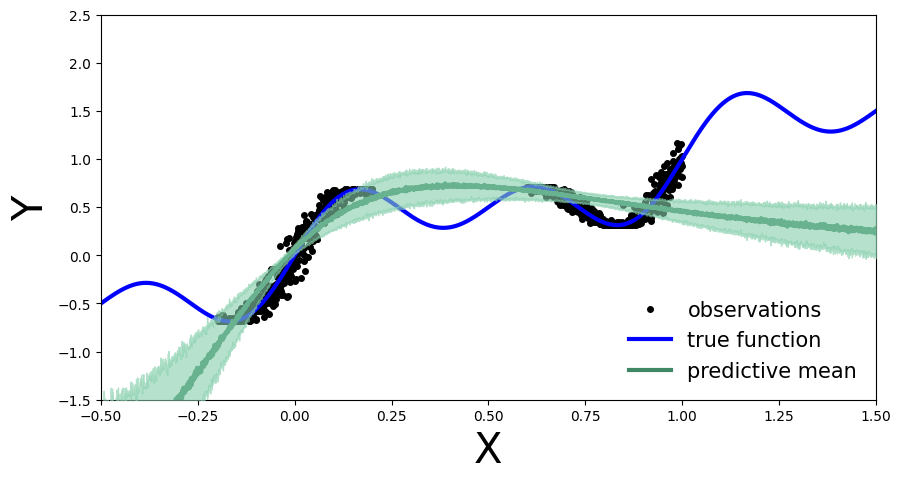

In [19]:
plot_uncertainty_bands(x_test, y_preds)

In the same way as Deep Ensembles, MC-Dropout allows us to have an uncertainty estimate next to our point wise predictions. However, for the given use-case this has come with the cost of an overall drop in the model's performance on the training regions. We observe this because at every pass through our network we randomly choose which nodes to keep, so one could argue that we hinder the networks optimal performance.

### Conformal prediction

Conformal prediction is a statistical uncertainty quantification approach that has gained interest in the Machine Learning community more recently. Originally proposed by [Vovk et al.](https://www.jmlr.org/papers/volume9/shafer08a/shafer08a.pdf), it allows us to construct statistically rigorous uncertainty bands around our predictions, without requiring any modifications to our prediction model. This is achieved by comparing true and predicted values on out-of-sample data (more precisely we are looking at _inductive_ conformal prediction), and computing an empirical quantile $\hat{q}$ based on these comparisons that defines the magnitude of the uncertainy bands. How we compare true and predicted values is a modelling decision, and there are different ways to do so. The comparison results are also called _(non)conformity scores_, hence the naming of the method.

If we follow the conformal recipe, with minimal assumptions our uncertainty bands will be statistically rigorous in the sense that they satisfy a nice property for any test sample $(X_{n+1},Y_{n+1})$:

$$ \mathbb{P}(Y_{n+1} \in \hat{C}(X_{n+1})) \ge 1-\alpha,$$ i.e. with probability at least $1-\alpha$, our computed uncertainty band $\hat{C}(X_{n+1})$ around our point estimate $\hat{Y}_{n+1}$ will contain the _true_ unknown value $Y_{n+1}$. This is called a (marginal) coverage guarantee, and provides us with a measure of confidence in the quality of our uncertainty bands.

We will now see that the implementation of conformal prediction for our example is in fact very simple, which is part of its attractiveness.

**Training**

Firstly, we split our training samples into two different data sets, the true training set and a hold-out data set, which we call the calibration set (you can think of it as a specific kind of validation set). We will take 20% of our data for calibration. Usually this is a random sample, but for reproducebility we select them evenly spaced.

In [20]:
# split data into training and calibration sets
x, y = get_simple_data_train()
cal_idx = np.arange(len(x), step=1/0.2, dtype=np.int64)
# cal_idx = np.random.choice(len(x), size=int(len(x) * 0.2), replace=False) # random selection
mask = np.zeros(len(x), dtype=bool)
mask[cal_idx] = True
x_cal, y_cal = x[mask], y[mask]
x_train, y_train = x[~mask], y[~mask]

 Then, we train a single standard (non-Bayesian) MLP on the true training set:

In [21]:
net = MLP(hidden_dim=10, n_hidden_layers=5)
net = train(net, (x_train, y_train))

  0%|          | 0/3000 [00:00<?, ?it/s]

**Evaluate**

Same as before, we first visualize how the MLP performs on the entire data domain of our input variable $x$. We see that training it on only 80% instead of all available data did not notably change its performance.

In [22]:
# compute predictions everywhere
x_test = torch.linspace(-.5, 1.5, 1000)[:, None]
y_preds = net(x_test).clone().detach().numpy()

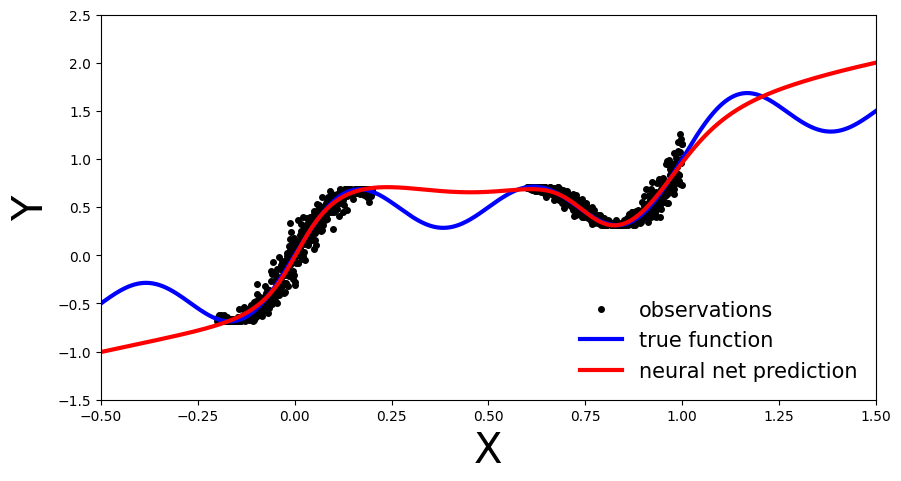

In [23]:
plot_predictions(x_test, y_preds)

We now perform the conformal prediction procedure to obtain our uncertainty bands. In the simplest case, our comparison of predicted and true values on the calibration data is achieved by simply looking at the residuals $|y-\hat{y}|$, which form our _conformity scores_. We then compute $\hat{q}$ as the $\left\lceil \frac{(n+1)(1-\alpha)}{n} \right\rceil$ empirical quantile of these residuals, and form our uncertainty bands for every test sample as $\hat{C}(X_{n+1})=[\hat{f}(x_{n+1})-\hat{q},\, \hat{f}(x_{n+1}) +\hat{q}].$ Our desired coverage rate is $(1-\alpha) \in [0,1]$, which we set to 90% (i.e. choose $\alpha=0.1$).


In [24]:
# compute calibration residuals
y_cal_preds = net(x_cal).clone().detach()
resid = torch.abs(y_cal - y_cal_preds).numpy()

In [25]:
# compute conformal quantile
alpha = 0.1
n = len(x_cal)
q_val = np.ceil((1 - alpha) * (n + 1)) / n
q = np.quantile(resid, q_val, method="higher")

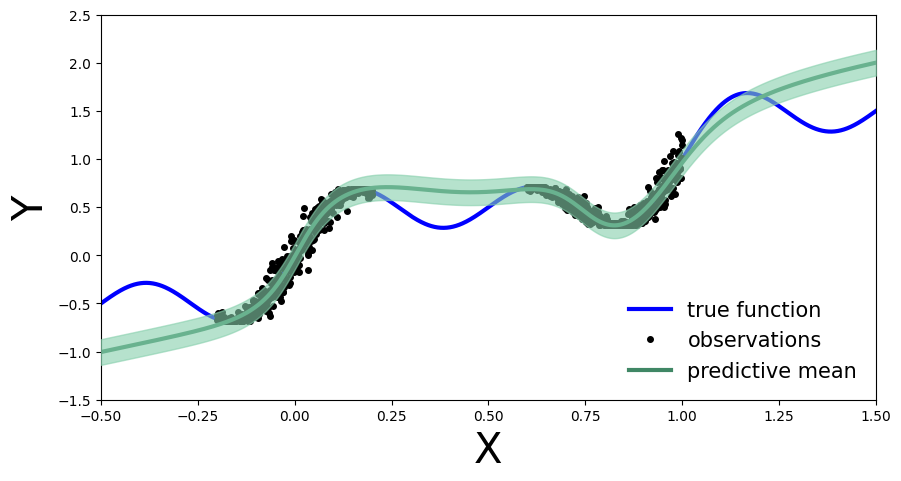

In [26]:
# true function
x_true = np.linspace(-.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# generate plot
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([-.5, 1.5])
plt.ylim([-1.5, 2.5])
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
ax.plot(x, y, 'ko', markersize=4, label="observations")
ax.plot(x_test, y_preds, '-', linewidth=3, color="#408765", label="predictive mean")
ax.fill_between(x_test.ravel(), y_preds - q, y_preds + q, alpha=0.6, color='#86cfac', zorder=5)

plt.legend(loc=4, fontsize=15, frameon=False);

We now obtain an uncertainty band around each test set prediction, which is informed by our performance on the calibration data (as quantified by the residuals). We can also compare our empirical coverage on the available test data against our target coverage of 90%:

In [27]:
# compute empirical coverage across whole test domain
cov = np.mean(((y_preds - q) <= y_true) * ((y_preds + q) >= y_true))
print(f"Empirical coverage: {cov:%}")

Empirical coverage: 54.900000%


We notice that the empirical coverage does not match our target coverage, suggesting that the conformal procedure is not working well for our given test samples (we are under-covering). This is mainly due to the fact that our calibration data, which is selected from available observations, is very localized and therefore not representative of the whole test domain. In other words, the information we get from the calibration data does not translate well to the whole test domain. Therefore the computed quantile $\hat{q}$ is inadequate on unseen sample spaces. Compare this to our empirical coverage for test samples from the domain of our calibration data:


In [28]:
# compute empirical coverage only on previously observed test domain
mask = (x_true >= -.2) * (x_true < 0.2) + (x_true >= .6) * (x_true < 1)
cov = np.mean(((y_preds[mask] - q) <= y_true[mask]) * ((y_preds[mask] + q) >= y_true[mask]))
print(f"Empirical coverage: {cov:%}")

Empirical coverage: 100.000000%


Here we are in fact over-covering, i.e. being overly conservative in the magnitude of our uncertainty bands. Note that the coverage guarantee only holds _marginally_, i.e. across _all possible_ sets of calibration and test samples; this is particularly obvious in our case. Other factors playing a role in obtaining useful uncertainty bands are the choice of $\alpha$, size of the calibration set and the predictive model's performance.

## Exercise: Detecting Distribution Shift on MNIST

In this exercise we will compare Bayesian NNs with deterministic NNs on a distribution shift detection task. To do this, we'll monitor the predictive entropy as the distribution gradually shifts.  A model with better uncertainty quantification should become less certain---that is, have a more entropic predictive distribution---as the input distribution shifts.  Mathematically, our quantity of interest is:
$$ \mathbb{H}[y | x^{*}, D] = - \sum_{y} p(y | x^{*}, D) \log p(y | x^{*}, D)$$ where $p(y | x^{*}, D)$ is the predictive distribution: $$ p(y | x^{*}, D) = \int_{\theta} p(y | x^{*}, \theta) \ p(\theta | D) \ d \theta.$$ The goal is to obtain something similar to Figure #4 from the paper [Multiplicative Normalizing Flows for Variational Bayesian Neural Networks](https://arxiv.org/abs/1603.04733), comparing MC dropout, ensembles, and a Bayesian NN.

We will be using the well-known MNIST dataset, a set of 70,000 hand-written digit images, and we will generate a gradual distribution shift on the dataset by rotating the images. As such, the final plot will depict the change in the entropy of the predictive distribution (y-axis) as degree of rotation increases (x-axis). The paper above shows the result for one image.  We, on the other hand, will average over multiple images to make a better comparison between models.

We'll use rotation to simulate a smooth shift. Here's how you can rotate a given image:

In [29]:
from PIL import Image
from torchvision import datasets
from torch.nn.functional import softmax
from torchvision.transforms.functional import rotate

In [30]:
def imshow(image):
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [31]:
def show_rotation_on_mnist_example_image():
    mnist_train = datasets.MNIST('../data', train=True, download=True)
    image = Image.fromarray(mnist_train.data[0].numpy())
    imshow(image)
    rotated_image = rotate(image, angle=90)
    imshow(rotated_image)

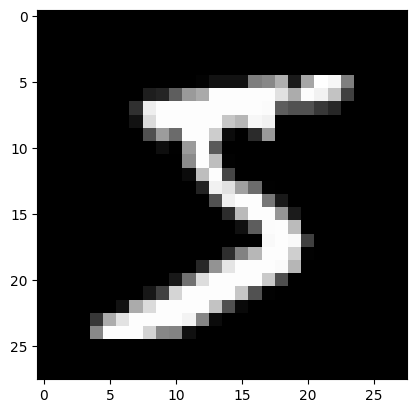

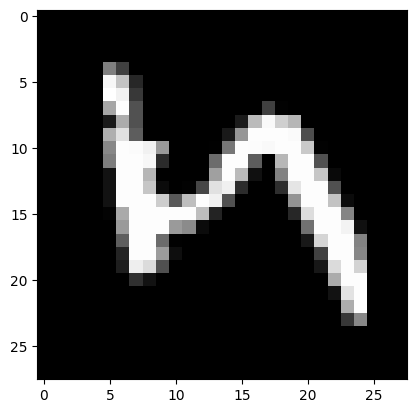

In [32]:
show_rotation_on_mnist_example_image()

Let's setup the training and testing data:

In [33]:
def get_mnist_data(train=True):
    mnist_data = datasets.MNIST('../data', train=train, download=True)
    x = mnist_data.data.reshape(-1, 28 * 28).float()
    y = mnist_data.targets
    return x, y

x_train, y_train = get_mnist_data(train=True)
x_test, y_test = get_mnist_data(train=False)

Now that we have the data, let's start training neural networks.

### Deterministic Network

We will reuse our MLP network architecture with different hyperparameters:

In [34]:
net = MLP(input_dim=784, output_dim=10, hidden_dim=30, n_hidden_layers=3)

**Training**

In [35]:
def train_on_mnist(net):
    x_train, y_train = get_mnist_data(train=True)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    batch_size = 250

    progress_bar = trange(20)
    for _ in progress_bar:
        for batch_idx in range(int(x_train.shape[0] / batch_size)):
            batch_low, batch_high = batch_idx * batch_size, (batch_idx + 1) * batch_size
            optimizer.zero_grad()
            loss = criterion(target=y_train[batch_low:batch_high], input=net(x_train[batch_low:batch_high]))
            progress_bar.set_postfix(loss=f'{loss / batch_size:.3f}')
            loss.backward()
            optimizer.step()
    return net

In [36]:
net = train_on_mnist(net)

  0%|          | 0/20 [00:00<?, ?it/s]

**Test**

In [37]:
def accuracy(targets, predictions):
  return (targets == predictions).sum() / targets.shape[0]

In [38]:
def evaluate_accuracy_on_mnist(net):
    test_data = get_mnist_data(train=False)
    x_test, y_test = test_data
    net.eval()
    y_preds = net(x_test).argmax(1)
    acc = accuracy(y_test, y_preds)
    print("Test accuracy is %.2f%%" % (acc.item() * 100))

In [39]:
evaluate_accuracy_on_mnist(net)

Test accuracy is 92.73%


### Rotating the images

Now let's compute predictive entropy on some rotated images...

First we will generate the rotated images with an increasing rotation angle from the test images. We use a subset of the MNIST test set for evaluation:

In [40]:
def get_mnist_test_subset(n_test_images):
    mnist_test = datasets.MNIST('../data', train=False, download=True)
    x = mnist_test.data[:n_test_images].float()
    y = mnist_test.targets[:n_test_images]
    return x, y

In [41]:
n_test_images = 100
x_test_subset, y_test_subset = get_mnist_test_subset(n_test_images=n_test_images)

In [42]:
rotation_angles = [3 * i for i in range(0, 31)] # use angles from 0 to 90 degrees
rotated_images = [rotate(x_test_subset, angle).reshape(-1, 28 * 28) for angle in rotation_angles]

Evaluate the trained MLP on the rotated images:

In [43]:
y_preds_deterministic = [softmax(net(images), dim=-1) for images in rotated_images]

The [information entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) $H$ of a probability distribution $p$ over a discrete random variable $X$ with possible outcomes $x_1, \ldots, x_N$, occuring with probabilities $p(x_i) := p_i$ is given by: $$ H(p) = - \sum_{i=1}^{N} p_i \log p_i $$
The entropy quantifies the uncertainty of a probability distribution in the sense, that the more uncertain the outcome a hypothetical experiment with drawing from the distribution is the higher the entropy. Highest is for an equal distribution of probability mass over all possible outcomes.
In our case the deterministic NN estimates a probability distribution over the ten digits as classes on MNIST for each image. For the rotated images we can thus calculate the entropy over the rotation angle.

> **1.1 How do you expect the entropy to behave with increasing rotation angle of the images?**

> **1.2 Implement a function for calculating the entropy according to the formula above.**

In [44]:
def entropy(p):
  p = np.array(p)

  return -(p * np.log(p)).sum()

Now we can calculate the accuracies and entropies for all rotated images and plot both:

In [45]:
def calculate_accuracies_and_entropies(y_preds):
    accuracies = [accuracy(y_test_subset, p.argmax(axis=1)) for p in y_preds]
    entropies = [np.mean(entropy(p.detach().numpy())) for p in y_preds]
    return accuracies, entropies

In [46]:
def plot_accuracy_and_entropy(add_to_plot):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlim([0, 90])
    plt.xlabel("Rotation Angle", fontsize=20)

    add_to_plot(ax)

    plt.legend()
    plt.show()

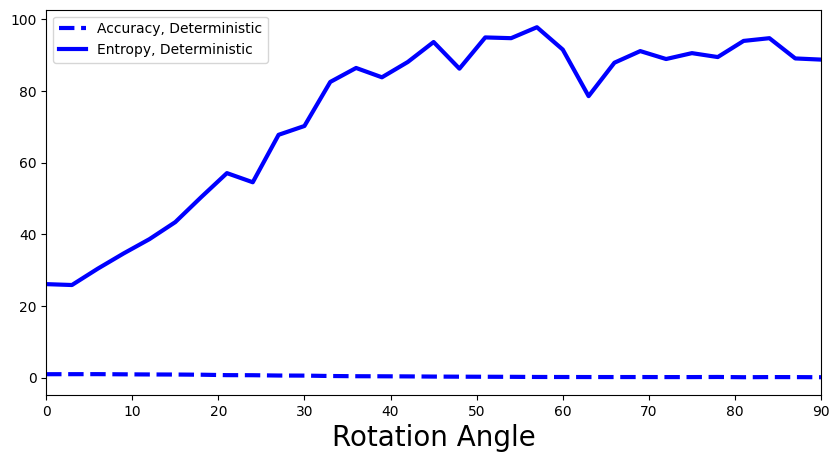

In [47]:
def add_deterministic(ax):
    accuracies, entropies = calculate_accuracies_and_entropies(y_preds_deterministic)
    ax.plot(rotation_angles, accuracies, 'b--', linewidth=3, label="Accuracy, Deterministic")
    ax.plot(rotation_angles, entropies, 'b-', linewidth=3, label="Entropy, Deterministic")
plot_accuracy_and_entropy(add_deterministic)

> What is your interpretation of the plot above: Is the predictive entropy changing? If so, how would you explain this?



### Monte Carlo Dropout Network

Let's create our Dropout Network. We keep the network depth and hidden layer size the same as for the MLP for a fair model comparison

In [48]:
net_dropout = MLP(input_dim=784, output_dim=10, hidden_dim=30, n_hidden_layers=3, use_dropout=True)

**Training**

In [49]:
net_dropout = train_on_mnist(net_dropout)

  0%|          | 0/20 [00:00<?, ?it/s]

**Test**

In [50]:
evaluate_accuracy_on_mnist(net_dropout)

Test accuracy is 91.92%


**Evaluate on rotated images**

> **2.1 Sample 100 different dropout masks and average the predictions over them.**

In [51]:
from numpy.ma.core import mean
n_dropout_samples = 100
net_dropout.train()  # we set the model to train to 'activate' the dropout layer
y_preds_deterministic = [softmax(net(images), dim=-1) for images in rotated_images]

y_preds_dropout= [torch.mean(torch.stack([softmax(net_dropout(images), dim=-1) for k in range(n_dropout_samples)], dim=0), dim=0
                             ) for images in rotated_images]












# len(accuracies)


# y_preds_dropout = ...

> **2.2 What is the best way to average over the predictions? Should you first average the network output and then apply the softmax, or the other way around?**

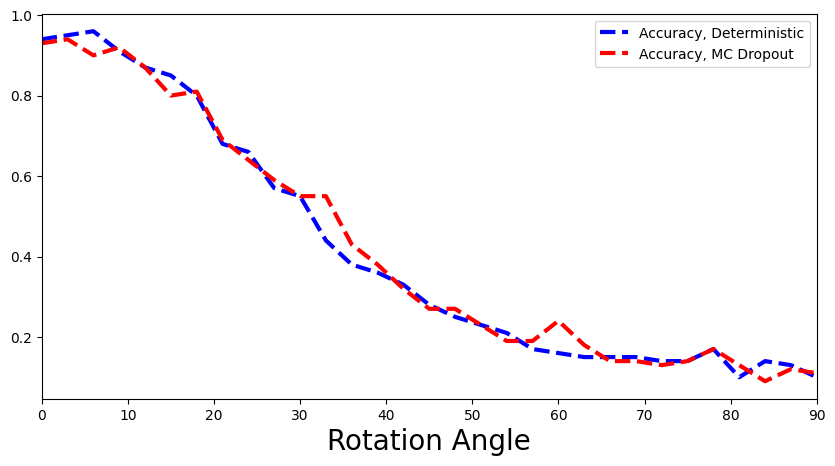

In [52]:
def add_deterministic_and_dropout(ax):
    accuracies, entropies = calculate_accuracies_and_entropies(y_preds_deterministic)
    ax.plot(rotation_angles, accuracies, 'b--', linewidth=3, label="Accuracy, Deterministic")
    # ax.plot(rotation_angles, entropies, 'b-', linewidth=3, label="Entropy, Deterministic")


    accuracies, entropies = calculate_accuracies_and_entropies(y_preds_dropout)
    ax.plot(rotation_angles, accuracies, 'r--', linewidth=3, label="Accuracy, MC Dropout")
    # ax.plot(rotation_angles, entropies, 'r-', linewidth=3, label="Entropy, MC Dropout")
plot_accuracy_and_entropy(add_deterministic_and_dropout)

> How does MLP compare with MC-Dropout Network? Are there any benefits of the (approximate) Bayesian approach?

### Deep Ensemble

Now let's investigate Deep Ensemble performance. We will use the exact same network hyperparameters as for the MLP:

> **3.1 Define and train an ensemble of five MLPs with the same hyperparameters as above.**

In [53]:
ensemble_size = 5

raise NotImplemented
# ensemble = ...

TypeError: ignored

**Training**

In [ ]:
raise NotImplemented

**Test**

> **3.2 Evaluate the accuracy of the ensemble prediction. How do you aggregate best over the multiple different predictions given by the members of the ensemble? What is the difference to the regression setting above?**

In [ ]:
raise NotImplemented
# y_preds = ...

acc = accuracy(y_test, y_preds)
print("Test accuracy is %.2f%%" % (acc.item() * 100))

**Evaluate on rotated images**

> **3.3 Again, average the predictions, but this time over the members of the ensemble.**

In [ ]:
raise NotImplemented
# y_preds_ensemble = ...

In [ ]:
def add_deep_ensemble(ax):
    accuracies, entropies = calculate_accuracies_and_entropies(y_preds_deterministic)
    ax.plot(rotation_angles, accuracies, 'b--', linewidth=3, label="Accuracy, Deterministic")
    ax.plot(rotation_angles, entropies, 'b-', linewidth=3, label="Entropy, Deterministic")

    accuracies, entropies = calculate_accuracies_and_entropies(y_preds_dropout)
    ax.plot(rotation_angles, accuracies, 'r--', linewidth=3, label="Accuracy, MC Dropout")
    ax.plot(rotation_angles, entropies, 'r-', linewidth=3, label="Entropy, MC Dropout")

    accuracies, entropies = calculate_accuracies_and_entropies(y_preds_ensemble)
    ax.plot(rotation_angles, accuracies, 'g--', linewidth=3, label="Accuracy, Deep Ensemble")
    ax.plot(rotation_angles, entropies, 'g-', linewidth=3, label="Entropy, Deep Ensemble")

In [ ]:
plot_accuracy_and_entropy(add_deep_ensemble)

> Are there any differences in the performance? Explain why you see or don't see any differences.

### Bayesian Neural Network

First install pyro package:

In [ ]:
!pip install pyro-ppl

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.distributions import Normal, Categorical
from torch.nn.functional import softmax
from tqdm.auto import trange, tqdm

> **4.1 Implement a Bayesian Neural Network for classifying MNIST digits. For orientation you can use the first tutorial.**

As a backbone use the MLP architecture introduced in the beginning of the notebook. However, because we will implement a custom *guide()*, define every layer explicitly.

In [ ]:
class My_MLP(nn.Module):
  '''
  Implement a MLP with 3 hidden layers, Tanh activation, no dropout or residual connections
  '''
  def __init__(self, in_dim=784, out_dim=10, hid_dim=200):
    super().__init__()
    assert in_dim > 0
    assert out_dim > 0
    assert hid_dim > 0
    # activation
    raise NotImplemented
    # self.act =

    #3 hidden layers
    raise NotImplemented
    # self.fc1 =
    # self.fc2 =
    # self.fc3 =
    # self.out =

  def forward(self, x):
    raise NotImplemented
    # pred = ...
    return pred

Initialize the network. You will have to access it's layers in your model and guide functions

In [ ]:
net = My_MLP()

In [ ]:
#confirm your layer names
for name, _ in net.named_parameters():
    print(name)

Define the model:
> Probablistic models in Pyro are specified as *model()* functions. This function defines how the output data is generated. Within the model() function, first, the pyro module *random_module()* converts the paramaters of our NN into random variables that have prior probability distributions. Second, in pyro *sample* we define that the output of the network is categorical, while the pyro *plate* allows us to vectorize this function for computational efficiency.

> Hint: remember we are doing a classification instead of regression!

You can 'cheat' a little: to speed up the training and limit a bit more the number of paramters we need to optimize, implement a BNN where only the **last layer** is Bayesian!

In [ ]:
def model(x_data, y_data):
  raise NotImplemented
  # define last layer priors
  # lift module parameters to random variables sampled from the priors
  # sample a regressor (which also samples w and b)

implement the guide(), *variational distribution*:
> the guide allows us to initialise a well behaved distribution which later we can optmize to approximate the true posterior

In [ ]:
softplus = torch.nn.Softplus()

def my_guide(x_data, y_data):
  raise NotImplemented
  # Output layer weight distribution priors
  # Output layer bias distribution priors
  # lift module parameters to random variables sampled from the priors
  # lifted_module = ...
  return lifted_module()

Initialize the stochastic variational inference approach (*hint: pyro import statements may help*)

In [ ]:
adam = pyro.optim.Adam({"lr": 1e-3})
raise NotImplemented
# svi = ...

**Training**

In [ ]:
pyro.clear_param_store()
batch_size = 250
bar = trange(30)
for epoch in bar:
  for batch_idx in range(int(x_train.shape[0] / batch_size)):
    batch_low, batch_high = batch_idx * batch_size, (batch_idx+1) * batch_size
    loss = svi.step(x_train[batch_low:batch_high], y_train[batch_low:batch_high])
    bar.set_postfix(loss=f'{loss / batch_size:.3f}')

**Test**

Use the learned *guide()* function to do predictions. Why? Because the *model()* function knows the **priors** for the weights and biases, **not** the learned posterior. The *guide()* contains the approximate posterior distributions of the parameter values, which we want to use to make the predictions.

In [ ]:
num_samples = 10
raise NotImplemented
# y_preds = ...

acc = accuracy(y_test, y_preds)
print("Test accuracy is %.2f%%" % (acc.item() * 100))

**Evaluate on rotated images**

In [ ]:
num_samples = 50
raise NotImplemented
# y_preds_bnn = ...

> **4.2 Show entropies for all four models. Which method is the best at detecting the distribution shift? How can you interpret this?**


In [ ]:
def add_bnn(ax):
  raise NotImplemented
  # accuracies and entropies for all four methods

plot_accuracy_and_entropy(add_bnn)

### Conformal prediction

In the previous example with simulated data, we used conformal prediction in the context of a regression task. Now, we are looking at a classification task. While the overall recipe is the same, there are differences in the specific design choices. In particular, our model outputs are now class probabilities $\hat{f}(x) \in [0,1]^K$, and our prediction sets are thus discrete sets $\hat{C}(X_{n+1})\subseteq \{1,\dots,K\}$, where $K=10$ in the case of MNIST. This is in contrast to the continuous uncertainty bands we obtained before, and influences how we design the comparison of true and predicted classes to obtain our _conformity scores_.

Since conformal prediction provides a measure of uncertainty via prediction sets _post-hoc_, i.e. without changes to model training procedure, we cannot directly compare conformal methods in terms of detecting distribution shift via entropy. Instead, we can look at empirical coverage and prediction set sizes.

:> **5.1 How do you expect empirical coverage and prediction set size to behave as we increase the rotation angle?**

**Training**

As in the previous example, we split our training samples into two different data sets, the true training set and the calibration set. We take the last 5k samples from the MNIST training data as calibration samples. We take the first 55k images as true training samples.

In [ ]:
# split data into training and calibration sets

raise NotImplemented
# x_cal, y_cal =
# x_tr, y_tr =

We will reuse the deterministic MLP network architecture from the beginning of the exercise and train it on the true training set:

In [ ]:
mlp = MLP(input_dim=784, output_dim=10, hidden_dim=30, n_hidden_layers=5)

In [ ]:
# training
mlp_optimizer = torch.optim.Adam(params=mlp.parameters(), lr=1e-4)
mlp_criterion = nn.CrossEntropyLoss()
batch_size = 250

bar = trange(30)
for epoch in bar:
  for batch_idx in range(int(x_train.shape[0] / batch_size)):
    batch_low, batch_high = batch_idx * batch_size, (batch_idx+1) * batch_size
    mlp_optimizer.zero_grad()
    loss = mlp_criterion(target=y_tr[batch_low:batch_high], input=mlp(x_tr[batch_low:batch_high]))
    bar.set_postfix(loss=f'{loss / batch_size:.3f}') #x.shape[0]
    loss.backward()
    mlp_optimizer.step()

**Test**

We can then check the test accuracy, just to ensure that our model trained well.

In [ ]:
evaluate_accuracy_on_mnist(mlp)

> What can we conclude if we compare accuracies to the model trained on full data?

**Conformal prediction for the  classification setting**

As previously mentioned, the choice of how to calculate the _conformity scores_ is a modelling decision. We will look at three different choices proposed in the recent literature:

1. The naive softmax method studied by [Sadinle et al. (2016)](https://arxiv.org/abs/1609.00451)
2. The adaptive prediction sets (APS) method studied by [Romano et al. (2020)](https://arxiv.org/abs/2006.02544)
3. The regularized adaptive prediction sets (RAPS) method studied by [Angelopoulos et al. (2021)](https://arxiv.org/abs/2009.14193)

For an easy introduction it is recommended to read chapters 1 and 2 from [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://arxiv.org/abs/2107.07511) by Angelopoulos & Bates, which includes code snippets that have been adapted to our task.

We start by defining some basic functions to compute the conformal quantile, as well as mean prediction size and empirical coverage.

In [ ]:
def quantile(scores, alpha=0.1):
  # compute conformal quantile

  raise NotImplemented
  # n =
  # q =
  # return np.quantile(...)

In [ ]:
def mean_set_size(sets):
  # mean prediction set size
  return np.mean(np.sum(sets, axis=1), axis=0)

In [ ]:
def emp_coverage(sets, target):
  # empirical coverage
  return sets[np.arange(len(sets)), target].mean()

#### Method 1: Naive softmax

In this method, we define our _conformity scores_ to be $s_i=1-\hat{\pi}_{x_i}(y_i)$ for some calibration sample $(x_i, y_i)$, i.e. one minues the softmax output of the true (correct) class. Our prediction set for some test sample $(x_{n+1}, y_{n+1})$ is then constructed as $\hat{C}(x_{n+1})=\{y'\in K:\hat{\pi}_{x_{n+1}}(y') \ge 1-\hat{q}\}$, i.e. collect all classes for which the softmax score is above the threshold $1-\hat{q}$. For examples on Imagenet, see [here](https://github.com/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-smallest-sets.ipynb).

In [ ]:
# Calculate conformal quantile on calibration data
cal_smx = softmax(mlp(x_cal), dim=1).detach().numpy()
scores = 1 - cal_smx[np.arange(len(cal_idx)), y_cal.numpy()]
q = quantile(scores)
print(f"Softmax cut-off level: {1-q}")

In [ ]:
# Evaluate prediction sets on test data
test_smx = softmax(mlp(x_test), dim=1).detach().numpy()

raise NotImplemented
# pred_sets =

print(f"Mean set size: {mean_set_size(pred_sets)}")
print(f"Empirical coverage: {emp_coverage(pred_sets, y_test.numpy())}")

The empirical coverage is close to target coverage 90% but does not quite reach it. Perhaps unintuitive is that the mean set size is <1. This is because for some test samples, the constructed approach can return empty sets. This happens if no softmax score is above the threshold. While there are workarounds to exclude empty sets, we do not consider them here.

Visualize for some test sample...

In [ ]:
img_idx = 0 # compare e.g. img_idx = 4, 4000
plt.imshow(x_test[img_idx].reshape(28, 28), cmap='gray', vmin=0, vmax=255)
print(f"Prediction set: {pred_sets[img_idx].nonzero()[0].tolist()}")

Now let's compute accuracy, set size and empirical coverage on some of the rotated MNIST images...

In [ ]:
deter_pred_means = []
for image in rotated_images:
  deter_pred_means.append(softmax(mlp(image), dim=1))

In [ ]:
acc = [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in deter_pred_means]
set_size = [mean_set_size(p.detach().numpy() >= (1-q)) for p in deter_pred_means]
cov = [emp_coverage(p.detach().numpy() >= (1-q), y_test[:n_test_images].numpy()) for p in deter_pred_means]

In [ ]:
t# generate plot

fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([0, 90])
plt.xlabel("Rotation Angle", fontsize=20)

ax.plot(rotation_angles, acc, 'b--', linewidth=3, label="Accuracy")
ax.plot(rotation_angles, set_size, 'b-', linewidth=3, label="Mean set size")
ax.plot(rotation_angles, cov, 'b:', linewidth=3, label="Emp. coverage")

plt.legend(loc=1, fontsize=15, frameon=False);

> **5.2 How do you interpret the plot? Is it what you expected, or is there a surprising trend? If so, how could you try to explain it?** (hint: empty sets)

#### Method 2: APS

In this method, we define our _conformity scores_ to be $s_i = \sum_{y'=1}^{K}\hat{\pi}_{x_i}(y')\,\mathbb{1}_{\{\hat{\pi}_{x_i}(y') > \hat{\pi}_{x_i}(y)\}}$ for some calibration sample $(x_i, y_i)$. In other words, we sum up the softmax probabilities of all classes until we reach the true class probability. In comparison to the previous method, this allows us to incorporate information not only on the true class, but also its relation to all other classes, and should lead to more adaptive prediction sets, at the cost of overall larger set sizes.

The prediction set for some test sample $(x_{n+1}, y_{n+1})$ is then constructed as $\hat{C}(x_{n+1})= \{y_1,\dots,y_k\}$, where $k=\sup\left\{k':\sum_{y'=1}^{k'}\hat{\pi}_{x_{n+1}}(y') < \hat{q}\right\}$. In other words, sort all softmax scores by magnitude and include all classes in the prediction set until the sum of their softmax scores hits $\hat{q}$. For examples on Imagenet, see [here](https://github.com/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-aps.ipynb).

In [ ]:
# Calculate conformal quantile on calibration data
cal_smx = softmax(mlp(x_cal), dim=1).detach().numpy()
cal_pi = cal_smx.argsort(axis=1)[:, ::-1]
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1)
scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[range(len(cal_idx)), y_cal.numpy()]
q = quantile(scores)
print(f"Softmax cut-off level: {q}")

In [ ]:
# Evaluate prediction sets on test data
test_smx = softmax(mlp(x_test), dim=1).detach().numpy()
test_pi = test_smx.argsort(axis=1)[:, ::-1]
test_srt = np.take_along_axis(test_smx, test_pi, axis=1).cumsum(axis=1)

raise NotImplemented
# pred_sets = np.take_along_axis(..., test_pi.argsort(axis=1), axis=1)

print(f"Mean set size: {mean_set_size(pred_sets)}")
print(f"Empirical coverage: {emp_coverage(pred_sets, y_test.numpy())}")

Visualize for some test sample...

In [ ]:
img_idx = 4 # compare e.g. img_idx = 4, 4000
plt.imshow(x_test[img_idx].reshape(28, 28), cmap='gray', vmin=0, vmax=255)
print(f"Prediction set: {pred_sets[img_idx].nonzero()[0].tolist()}")

Now let's compute accuracy, set size and empirical coverage on some of the rotated MNIST images...

In [ ]:
deter_pred_means = []
for image in rotated_images:
  deter_pred_means.append(softmax(mlp(image), dim=1))

In [ ]:
acc = [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in deter_pred_means]

In [ ]:
set_size, cov = [], []
for p in deter_pred_means:
  p = p.detach().numpy()
  p_pi = p.argsort(axis=1)[:, ::-1]
  p_srt = np.take_along_axis(p, p_pi, axis=1).cumsum(axis=1)
  pred_sets = np.take_along_axis(p_srt <= q, p_pi.argsort(axis=1), axis=1)
  set_size.append(mean_set_size(pred_sets))
  cov.append(emp_coverage(pred_sets, y_test[:n_test_images].numpy()))

In [ ]:
# generate plot

fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([0, 90])
plt.xlabel("Rotation Angle", fontsize=20)

ax.plot(rotation_angles, acc, 'b--', linewidth=3, label="Accuracy")
ax.plot(rotation_angles, set_size, 'b-', linewidth=3, label="Mean set size")
ax.plot(rotation_angles, cov, 'b:', linewidth=3, label="Emp. coverage")

plt.legend(loc=2, fontsize=15, frameon=False);

> **5.3 How do you interpret the plot? Is it what you expected?**

#### Method 3: RAPS

This method builds on APS and proposes an additional regularization term to decrease prediction set sizes, while maintaining the conformal coverage guarantee. This introduces additional parameters but strongly reduces set sizes, making it more useful in practice. The regularization term essentially adds probability mass as a "penalty" term $\lambda_{reg}$ to all softmax scores after a defined threshold $k_{reg}$ to reach the APS softmax threshold faster, resulting in smaller prediction sets. The general score construction is similar to APS. For further reading you can have a look at the paper (sections 2.1 and 2.2, see also Fig. 3). For examples on Imagenet, see [here](https://github.com/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-raps.ipynb).

In [ ]:
# Set RAPS regularization parameters
smx_classes = 10

lam_reg = 0.01 # Effect?
k_reg = 3 # Effect?

disallow_zero_sets = False # Set this to False in order to see the coverage upper bound hold
rand = True # Set this to True in order to see the coverage upper bound hold
reg_vec = np.array(k_reg * [0,] + (smx_classes - k_reg) * [lam_reg,])[None, :]
print(f"Probability mass penalty for each class: {reg_vec}")

> **5.4 Try out different parameter settings. What effects do $\lambda_{reg}$ and $k_{reg}$ have on regularization?**

In [ ]:
# Calculate conformal quantile on calibration data
cal_smx = softmax(mlp(x_cal), dim=1).detach().numpy()

cal_pi = cal_smx.argsort(axis=1)[:, ::-1]
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1)
cal_srt_reg = cal_srt + reg_vec
cal_L = np.where(cal_pi == y_cal.numpy()[:, None])[1]
n = len(cal_idx)

scores = cal_srt_reg.cumsum(axis=1)[np.arange(n), cal_L] - np.random.rand(n) * cal_srt_reg[np.arange(n), cal_L]
q = quantile(scores)
print(f"Softmax cut-off level: {q}")

In [ ]:
# Evaluate prediction sets on test data
test_smx = softmax(mlp(x_test), dim=1).detach().numpy()

test_pi = test_smx.argsort(1)[:, ::-1]
test_srt = np.take_along_axis(test_smx, test_pi, axis=1)
test_srt_reg = test_srt + reg_vec
test_srt_reg_cumsum = test_srt_reg.cumsum(axis=1)

if rand:
  indicators = (test_srt_reg.cumsum(axis=1) - np.random.rand(len(test_smx), 1) * test_srt_reg) <= q
else:
  indicators = (test_srt_reg.cumsum(axis=1) - test_srt_reg) <= q

if disallow_zero_sets:
  indicators[:, 0] = True

pred_sets = np.take_along_axis(indicators, test_pi.argsort(axis=1), axis=1)
print(f"Mean set size: {mean_set_size(pred_sets)}")
print(f"Empirical coverage: {emp_coverage(pred_sets, y_test.numpy())}")

> How do the metrics compare to those obtained using APS without regularization?

Visualize for some test sample...

In [ ]:
img_idx = 0 # compare e.g. img_idx = 4, 4000
plt.imshow(x_test[img_idx].reshape(28, 28), cmap='gray', vmin=0, vmax=255)
print(f"Prediction set: {pred_sets[img_idx].nonzero()[0].tolist()}")

Now let's compute accuracy, set size and empirical coverage on some of the rotated MNIST images...

In [ ]:
deter_pred_means = []
for image in rotated_images:
  deter_pred_means.append(softmax(mlp(image), dim=1))

In [ ]:
acc = [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in deter_pred_means]

In [ ]:
set_size, cov = [], []
for p in deter_pred_means:
  p = p.detach().numpy()
  p_pi = p.argsort(1)[:, ::-1]
  p_srt = np.take_along_axis(p, p_pi, axis=1)
  p_srt_reg = p_srt + reg_vec
  p_srt_reg_cumsum = p_srt_reg.cumsum(axis=1)

  if rand:
    indicators = (p_srt_reg.cumsum(axis=1) - np.random.rand(len(p), 1) * p_srt_reg) <= q
  else:
    indicators = (p_srt_reg.cumsum(axis=1) - p_srt_reg) <= q

  if disallow_zero_sets:
    indicators[:, 0] = True

  pred_sets = np.take_along_axis(indicators, p_pi.argsort(axis=1), axis=1)
  set_size.append(mean_set_size(pred_sets))
  cov.append(emp_coverage(pred_sets, y_test[:n_test_images].numpy()))

In [ ]:
# generate plot

fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([0, 90])
plt.xlabel("Rotation Angle", fontsize=20)

ax.plot(rotation_angles, acc, 'b--', linewidth=3, label="Accuracy")
ax.plot(rotation_angles, set_size, 'b-', linewidth=3, label="Mean set size")
ax.plot(rotation_angles, cov, 'b:', linewidth=3, label="Emp. coverage")

plt.legend(loc=2, fontsize=15, frameon=False);

> **5.5 How do you interpret the plot? Is it what you expected? How does it compare to APS without regularization?**

> **5.6 What do you conclude? Are conformal prediction methods able to identify the distribution shift caused by rotating the MNIST images?**